In [1]:
% pylab notebook
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

dc = datacube.Datacube()
# Replace '156' and 'cek156' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

Populating the interactive namespace from numpy and matplotlib


Failed to resolve driver datacube.plugins.index::s3aio_index


In [2]:
import os
os.chdir('/g/data/u46/users/ck9738/')

# Sentinal 2 A&B Geomedian notebook

what does this notebook do? 

In [3]:
def three_band_image_flat(ds, bands, time = 0, figsize = [10,10], title='string', projection = 'projected'):
    '''
    threeBandImage takes three spectral bands from a dataframe with no time dimention, and plots them on the RGB 
    bands of an image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    title - string that the plot should be given as a title
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is 
    in degrees or northings
    '''
    y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title(title, fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')
    plt.savefig('plots/sent/'+title + '.png')
    plt.show()
    #plt.close()

In [4]:

def threeBandImage(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands and plots them on the RGB bands of an image. 
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is in degrees or northings
    '''
    t, y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour][time].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    imshow(img_toshow)
    ax = plt.gca()
    ax.set_title(str(ds.time[time].values), fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')

In [38]:
%%time
#set up peramiters for sentinal data loadingfor first time period

Ssensors= ['s2a_ard_granule', 's2b_ard_granule'] #pick the sentinal satelites you want

Sbands_of_int =['red','blue','green','nir1','swir1'] #pick the sentinal bands that you want, here i am just using visible light  

Squery = {
        'lat': (-17.33, -17.41),
        'lon': (139.32, 139.40),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2015-01-07', '2016-08-09')
        }
# use s2b_ard_granule 	 for S2B
data_time1 = s2aws.load(product='s2a_ard_granule', measurements=Sbands_of_int, group_by='solar_day', **Squery)


CPU times: user 8.22 s, sys: 673 ms, total: 8.9 s
Wall time: 20.1 s


In [86]:
%%time
#set up peramiters for sentinal data loadingfor first time period

Ssensors= ['s2a_ard_granule', 's2b_ard_granule'] #pick the sentinal satelites you want

Sbands_of_int =['red','blue','green','nir1'] #pick the sentinal bands that you want, here i am just using visible light  

query = {
        'lat': (-17.450, -17.588),
        'lon': (140.679, 140.875),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-08-27', '2017-08-29')
        }
# use s2b_ard_granule 	 for S2B
#data_time2 = {}
data_time2 = s2aws.load(product='s2a_ard_granule', measurements=Sbands_of_int, group_by='solar_day', **query)
"""data_time2['s2a']=s2a_data
s2b_data = s2aws.load(product='s2b_ard_granule', group_by='solar_day', **query)
data_time2['s2b']=s2b_data"""

CPU times: user 1.84 s, sys: 44 ms, total: 1.88 s
Wall time: 1.63 s


In [ ]:
data_sent = {}


sensors_used = 0

for i in Ssensors:
    try:
        this_sensor = s2aws.load(product= i, group_by='solar_day', **query)
    
        #retreive projection infromation
        crs = this_sensor.crs
        crswkt = this_sensor.crs.wkt
        affine = this_sensor.affine
    
        #make a mask for full timeseries// if you aren't using a geomedian you may want this, but we don't need it
        #clear_pixelsa = this_sensor.pixel_quality != 2
        #clear_pixelsb = this_sensor.pixel_quality != 3
        #clear_pixels = clear_pixelsa * clear_pixelsb
        #clear_data = this_sensor.where(clear_pixels)
    
        data_sent[i] = this_sensor
        sensors_used = sensors_used + 1
        print(i+' done')
    except:
        print(i+'dose not have any imagry for this time')
        
        #use masked vs UNmasked for geomedian depending on requierments 

In [ ]:
data_time2 = xr.concat(data_sent.values(),'time')
data_time2 = data_time2.sortby('time')
data_time2.attrs['crs'] = crs
data_time2.attrs['affin|e'] = affine

In [39]:
data_time1

<xarray.Dataset>
Dimensions:  (time: 13, x: 902, y: 932)
Coordinates:
  * time     (time) datetime64[ns] 2015-08-12T01:01:32.459000 ...
  * y        (y) float64 -1.87e+06 -1.87e+06 -1.87e+06 -1.87e+06 -1.87e+06 ...
  * x        (x) float64 7.785e+05 7.785e+05 7.786e+05 7.786e+05 7.786e+05 ...
Data variables:
    red      (time, y, x) int16 357 362 370 362 366 369 361 360 357 358 363 ...
    blue     (time, y, x) int16 958 961 960 939 941 958 975 956 952 943 936 ...
    green    (time, y, x) int16 1051 1053 1071 1069 1062 1058 1051 1069 1066 ...
    nir1     (time, y, x) int16 158 156 164 162 159 165 159 170 156 162 147 ...
    swir1    (time, y, x) int16 115 115 105 105 108 108 116 116 116 116 111 ...
Attributes:
    crs:      EPSG:3577

#cast the data to float numbers so geomedian calculation will work
data_time1_flt = data_time1.astype(float,casting='safe')
data_time2_flt = data_time2.astype(float,casting='safe')
#data_land_flt = data_land.astype(float,casting='safe')

Sentinal_gm_1=GeoMedian().compute(data_time1_flt)


Sentinal_gm_2=GeoMedian().compute(data_time2_flt)

<IPython.core.display.Javascript object>


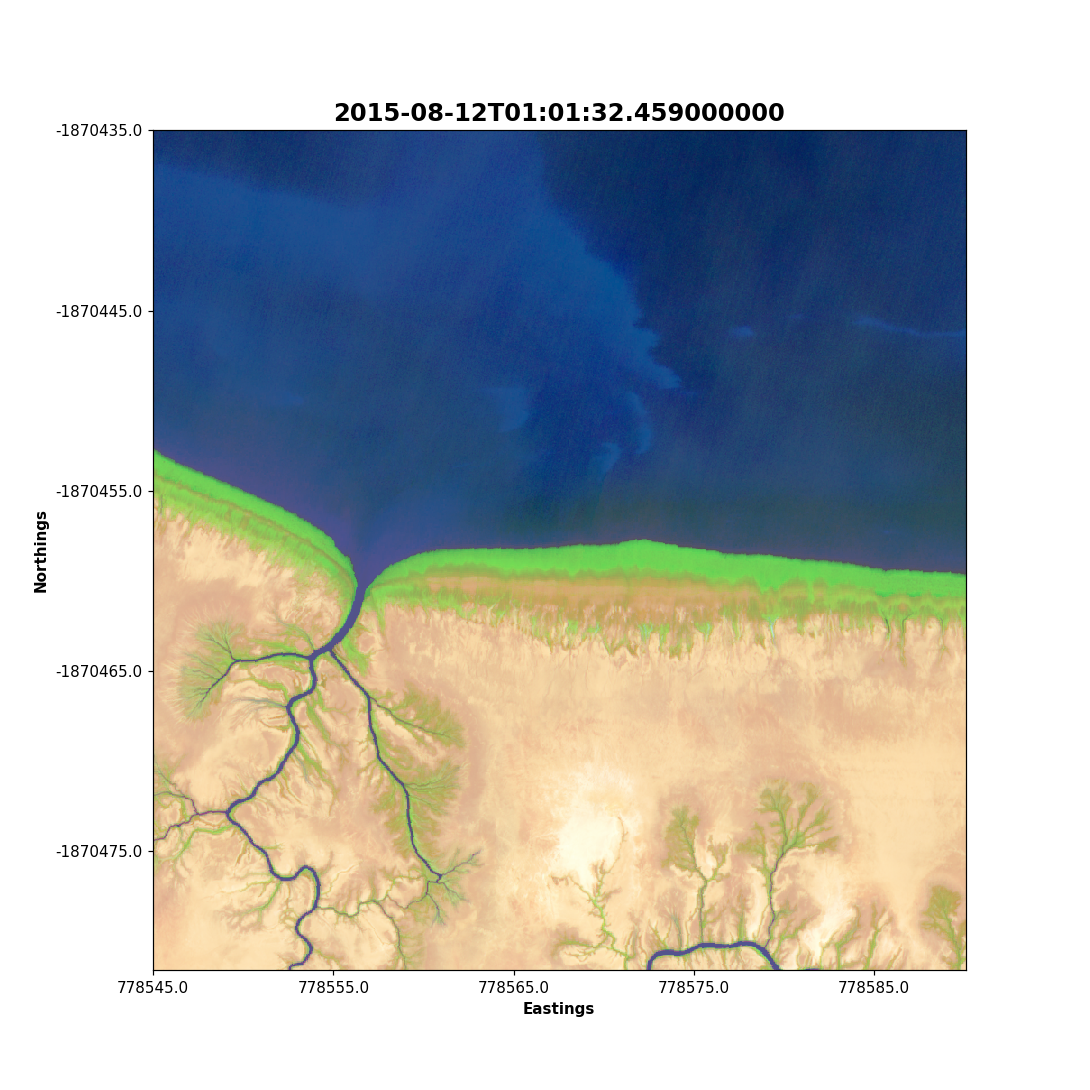

In [40]:
threeBandImage(data_time1, time = 0, bands=['swir1', 'nir1', 'green'])

<IPython.core.display.Javascript object>


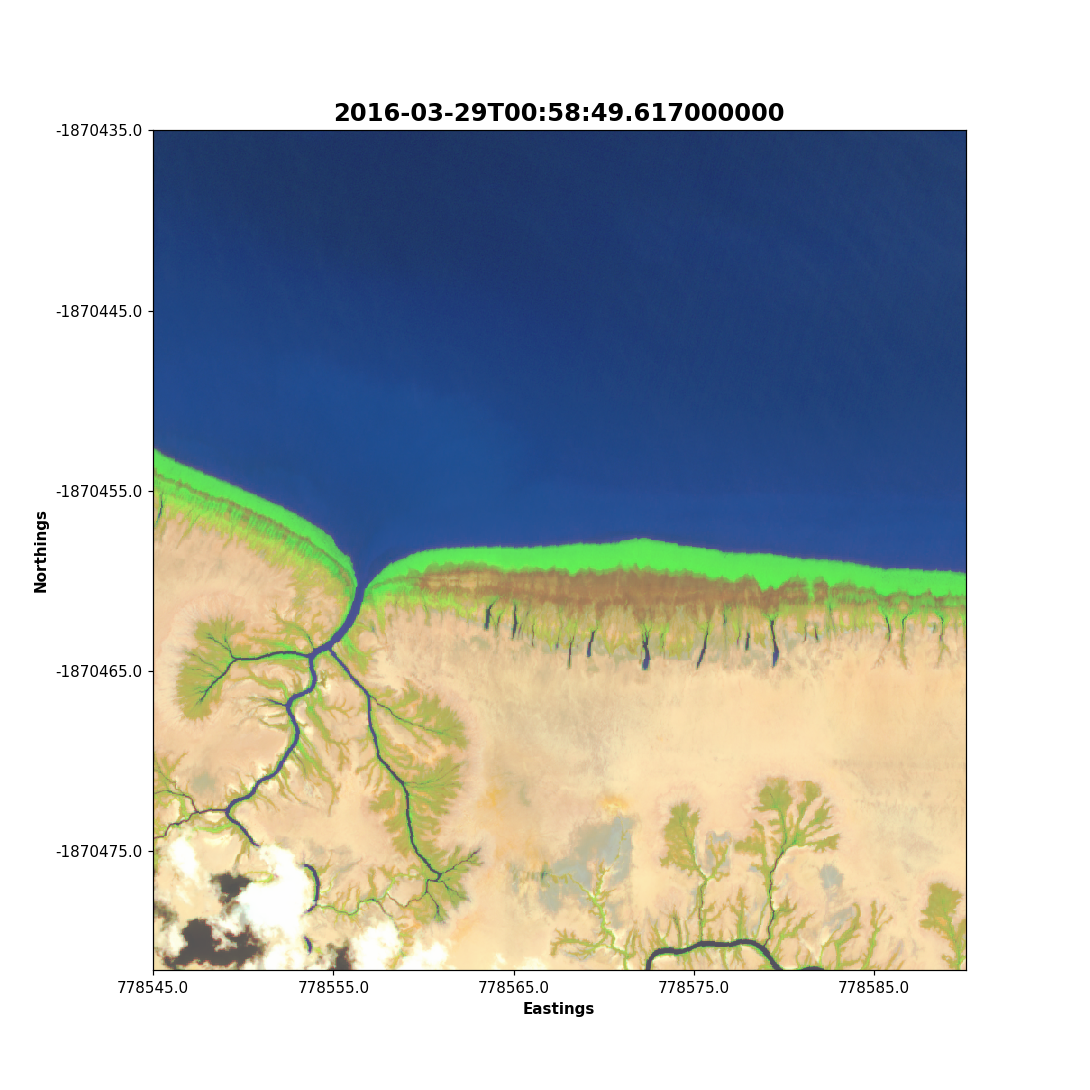

In [41]:
threeBandImage(data_time1, time = 6, bands=['swir1', 'nir1', 'green'])

In [89]:
NDVI_one = (data_time1['nir1']-data_time1['red'])/(data_time1['nir1']+data_time1['red'])
NDVI_two = (data_time2['nir1']-data_time2['red'])/(data_time2['nir1']+data_time2['red'])


In [90]:
NDVI_one = NDVI_one.squeeze()

In [91]:
NDVI_two = NDVI_two.squeeze()

In [92]:
NDVI_diff = NDVI_two-NDVI_one

In [93]:
NDVI_diff

<xarray.DataArray (y: 1666, x: 2185)>
array([[-0.096574, -0.123095, -0.111239, ...,  0.051702,  0.061254,  0.063978],
       [-0.100944, -0.087798, -0.119473, ...,  0.081481,  0.068635,  0.077935],
       [-0.128082, -0.077977, -0.102433, ...,  0.091292,  0.072185,  0.101968],
       ...,
       [ 0.031642,  0.041185,  0.031649, ...,  0.016565,  0.016484,  0.011152],
       [ 0.046555,  0.046041,  0.038914, ...,  0.004166,  0.000675,  0.011876],
       [ 0.046236,  0.072202,  0.05079 , ...,  0.006411, -0.003038,  0.002201]])
Coordinates:
  * y        (y) float64 -1.893e+06 -1.893e+06 -1.893e+06 -1.893e+06 ...
  * x        (x) float64 9.215e+05 9.215e+05 9.216e+05 9.216e+05 9.216e+05 ...

<IPython.core.display.Javascript object>


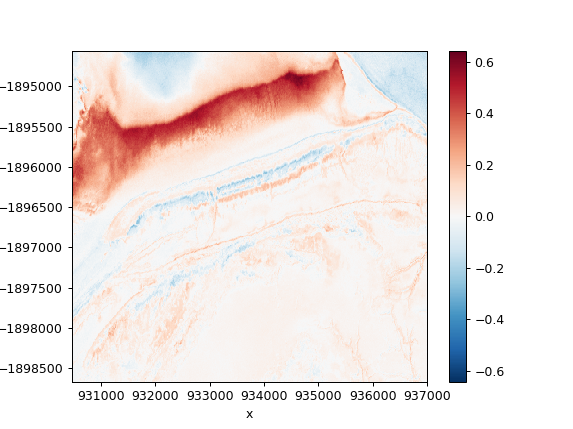

In [96]:
fig, ax = plt.subplots()

In [97]:
NDVI_diff.plot()

In [18]:
maxes = ([np.amax(NDVI_one),np.amax(NDVI_two),np.amax(NDVI_diff)])
minns = ([np.amin(NDVI_one),np.amax(NDVI_two),np.amin(NDVI_diff)])

In [19]:
ultimax = np.amax(maxes)
ultimin = np.amin(minns)

In [20]:
ultimin

-0.7920730537543644

In [24]:
ndvi_cmap = 'Spectral'
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap)

<IPython.core.display.Javascript object>


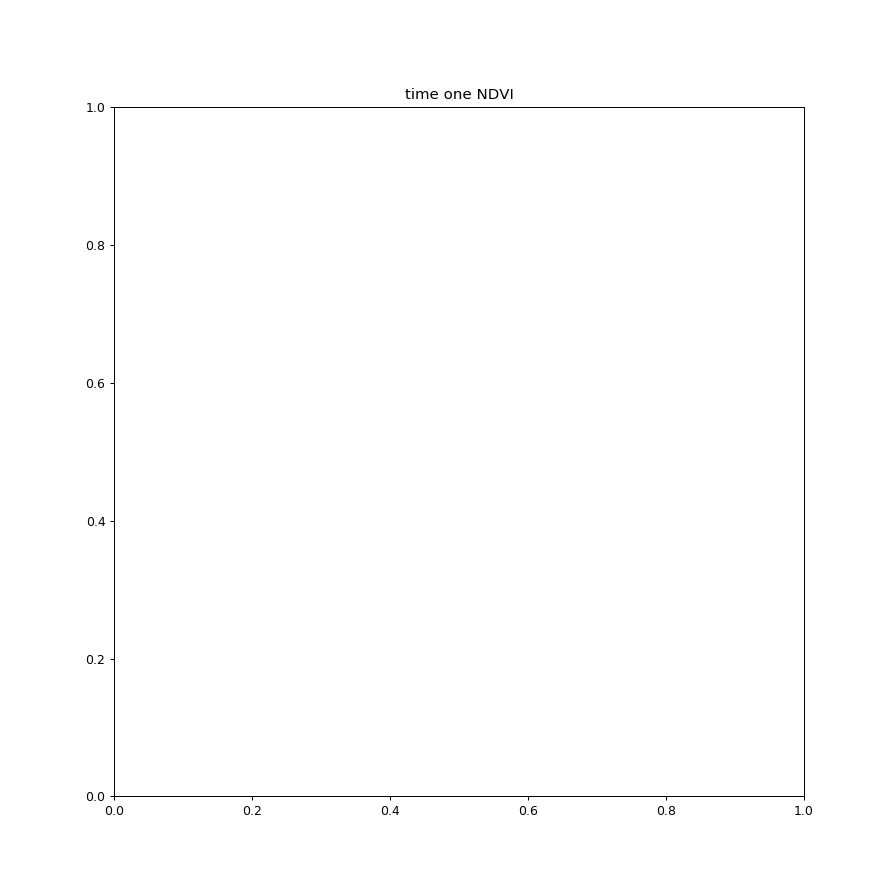

TypeError: Invalid dimensions for image data

In [25]:
fig, ax = plt.subplots(figsize=(20,20))
plt.title('time one NDVI')
norm = mpl.colors.Normalize(vmin=-0.05, vmax=0.5)
cax = ax.imshow(NDVI_one, cmap='Spectral', norm=ndvi_norm)
cbar = fig.colorbar(cax, fraction=0.038, pad=0.04)
plt.savefig('plots/sent/before_ndvi.png')
plt.show()

<IPython.core.display.Javascript object>


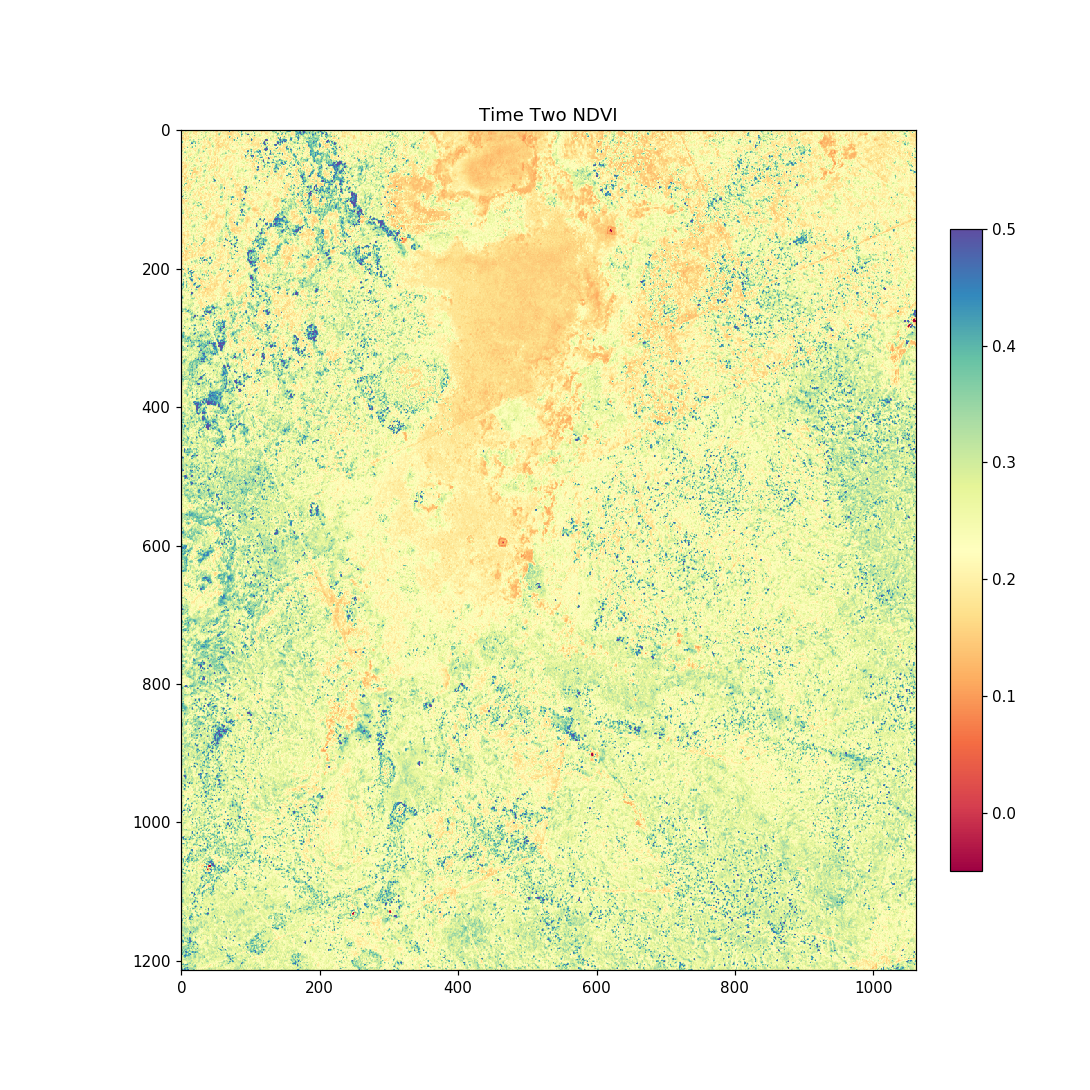

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Time Two NDVI')
norm = mpl.colors.Normalize(vmin=-0.05, vmax=0.5)
cax = ax.imshow(NDVI_two, cmap='Spectral', norm=norm )
cbar = fig.colorbar(cax, fraction=0.038, pad=0.04)
plt.savefig('plots/sent/ndvi_after.png')
plt.show()

<IPython.core.display.Javascript object>


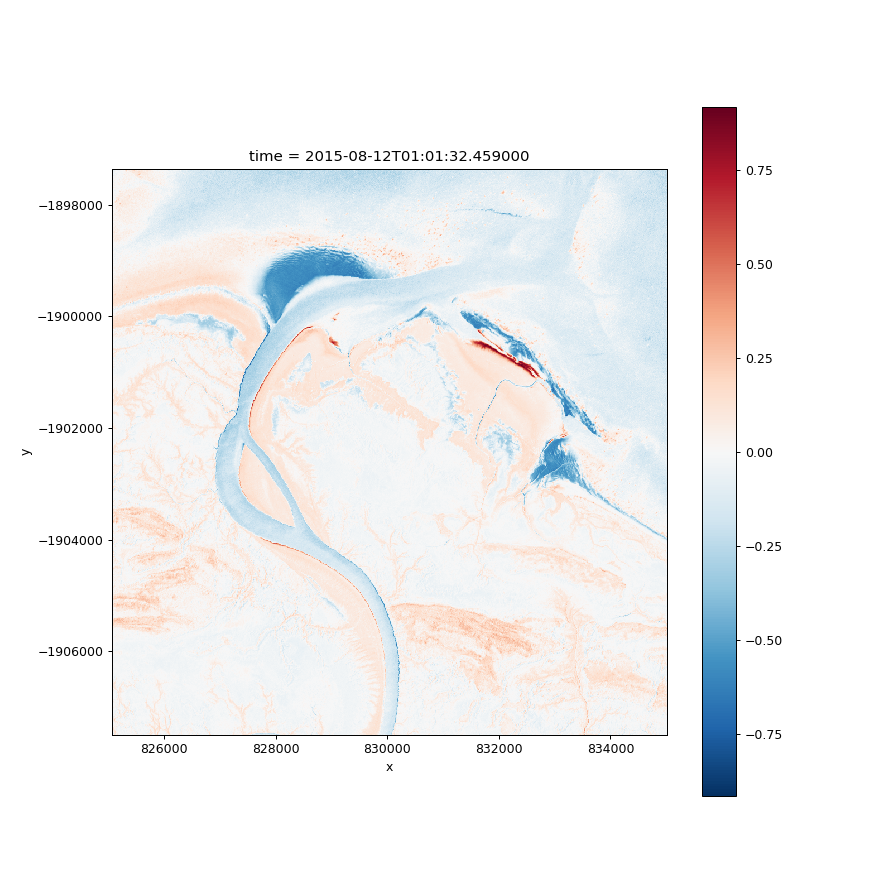

TypeError: Invalid dimensions for image data

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
plt.title('difference in NDVI')
norm = mpl.colors.Normalize(vmin=-0.25, vmax=0.25)
cax = ax.imshow(NDVI_diff, cmap='Spectral', norm=norm )
#cbar = fig.colorbar(cax, fraction=0.038, pad=0.04)

#plt.savefig('plots/sent/ndvi_change.png')
plt.show()


In [20]:
NDVI_one.data.shape

(1115, 118)

In [21]:
NDVI_one.data.ravel()

array([ 0.36365093,  0.30388679,  0.3171684 , ...,  0.33300199,
        0.3031089 ,  0.30166519])

In [22]:
plt.scatter(NDVI_one.data.ravel(),NDVI_two.data.ravel(), alpha=0.1)

In [23]:
dc.load(product=landsat, like=mysentinelxarray)

NameError: name 'landsat' is not defined